# Visa Preprocessing

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Ingestion

In [2]:
def load_data(url):
    init_data = pd.read_csv(url, sep = ",")
    data = init_data.copy()
    return data

In [3]:
df = load_data("Clean_Visa_data.csv")
df_processed = df.copy()

In [4]:
df_processed.head(1)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied


## 2. Missing values and Duplicate chec

In [5]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    if missing_values.sum()>0:
        print(missing_values[missing_values>0])
    else:
        print("No missing values as expected from EDA")

def check_duplicates(df):
    duplicates = df.duplicated().sum()
    if duplicates>0:
        print(f"Percentage of duplicates: {(duplicates/len(duplicates))*100:.2f}%")
    else:
        print("There are no duplicates as expected from EDA")

In [6]:
check_missing_values(df_processed)
check_duplicates(df_processed)

No missing values as expected from EDA
There are no duplicates as expected from EDA


In [7]:
df_processed.head(2)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified


## Feature Engineering

Features to be engineered
Annual wage, need training_has experiece, need training_hasno experience, wage vs region,

In [8]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [9]:
def feature_engineering(df_processed):
    # Age of establishment
    current_year = datetime.now().year
    df_processed["Age_of_estab"] = current_year - df_processed["yr_of_estab"]

    #Prevailing wage columns
    df_processed["unit_of_wage"] = df_processed["unit_of_wage"].str.strip()
    wage_unit={
        "Hour": 2080, #8 hours against 52 weeks
        "Week": 52,
        "Month": 12,
        "Year": 1
    }

    df_processed["annual_wage"] = df_processed["prevailing_wage"]* df_processed['unit_of_wage'].map(wage_unit)
    df_processed["monthly_wage"] = df_processed["annual_wage"]/12
    df_processed["weekly_wage"] = df_processed["annual_wage"]/52
    df_processed["hourly_wage"] = df_processed["annual_wage"]/2080

    

In [10]:
feature_engineering(df_processed)

In [11]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wage,monthly_wage,weekly_wage,hourly_wage
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied,18,1231782.032,102648.502667,23688.116000,592.202900
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified,23,83425.650,6952.137500,1604.339423,40.108486
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied,17,122996.860,10249.738333,2365.324231,59.133106
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied,128,83434.030,6952.835833,1604.500577,40.112514
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified,20,149907.390,12492.282500,2882.834423,72.070861


## 2. Outlier Detection and Handling

### Outlier Detection

In [12]:
def categorical_numerical(df):
    num_col = df.select_dtypes(include=["number"]).columns
    cat_col = df.select_dtypes(include=["object"]).columns
    cat_col = cat_col.drop('case_id') #considering dropping soon

    return num_col, cat_col

In [13]:
numerical_features, categorical_features = categorical_numerical(df_processed)

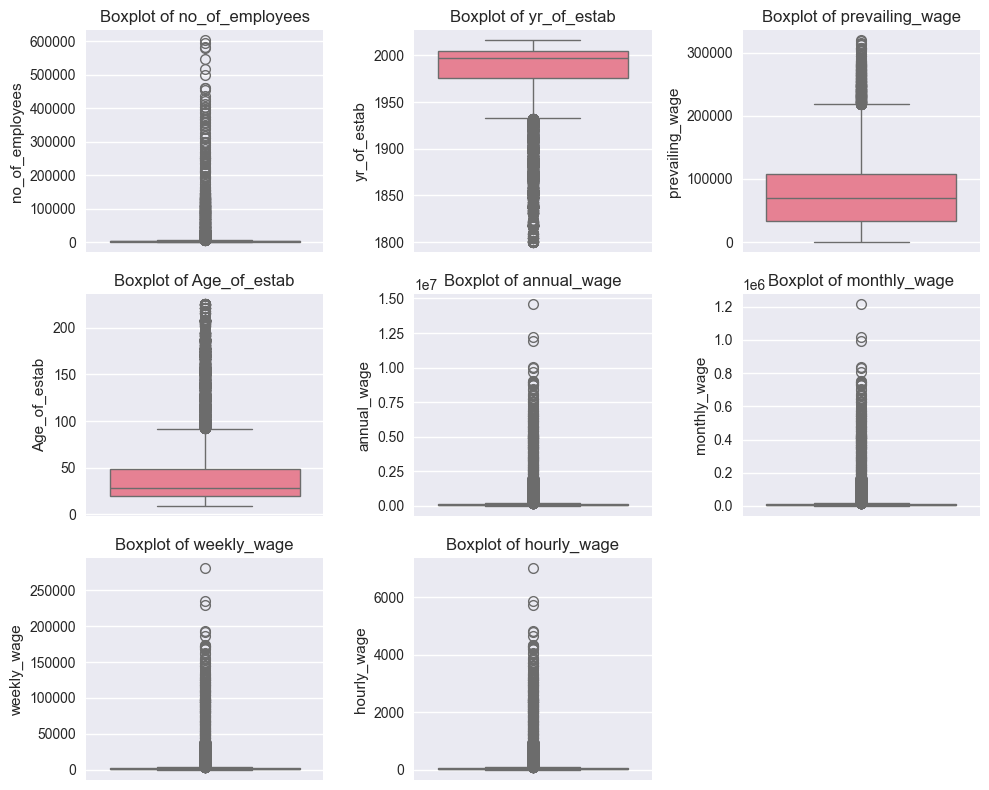

In [14]:
plt.figure(figsize=(10,8))

for i, variable in enumerate(numerical_features):
    plt.subplot(3,3, i+1)
    sns.boxplot(data=df_processed, y=variable)
    plt.title(f"Boxplot of {variable}")
    plt.tight_layout()
plt.show()

### Outlier Handling

In [15]:
def cap_outlier(df, columns):
    
    outliers_capped = 0
    for col in columns:
        Q1 = df_processed[col].quantile(0.25)
        Q3 = df_processed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_before = ((df_processed[col]< lower_bound)| (df[col] > upper_bound)).sum()
        if outliers_before > 0:
            df_processed[col] = np.where(df_processed[col] < lower_bound, lower_bound, df_processed[col])
            df_processed[col] = np.where(df_processed[col]> upper_bound, upper_bound, df_processed[col])
            outliers_capped += outliers_before
            print(f"\n{col}: Capped {outliers_before} outliers")

    
    print(f'\nTotal outliers capped: {outliers_capped}')
    print(f"Dataset shape after outlier treatment: {df_processed.shape}")

In [16]:
cap_outlier(df_processed, numerical_features)


no_of_employees: Capped 1556 outliers

yr_of_estab: Capped 3260 outliers

prevailing_wage: Capped 427 outliers

Age_of_estab: Capped 3260 outliers

annual_wage: Capped 2387 outliers

monthly_wage: Capped 2387 outliers

weekly_wage: Capped 2387 outliers

hourly_wage: Capped 2387 outliers

Total outliers capped: 18051
Dataset shape after outlier treatment: (25480, 17)


## 3. Handling Skewness

In [17]:
def handle_skewness(df_processed, column, threshold = 0.5):
    for var in column:
        skewness = df_processed[var].skew()
        if skewness > threshold:
            print(f"\n{var} is right-skewed")
            df_processed[f"{var}_log"] = np.log1p(df_processed[var])

        elif skewness < threshold:
            print(f"\n{var} is left-skewed")
            df_processed[f"{var}_square"] = np.square(df_processed[var])
        else:
            print(f"\n{var} is moderately skewed or moderately symmetric")
        
      

In [18]:
handle_skewness(df_processed, numerical_features)


no_of_employees is right-skewed

yr_of_estab is left-skewed

prevailing_wage is right-skewed

Age_of_estab is right-skewed

annual_wage is right-skewed

monthly_wage is right-skewed

weekly_wage is right-skewed

hourly_wage is right-skewed


## Encoding

In [19]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wage,monthly_wage,weekly_wage,hourly_wage,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wage_log,monthly_wage_log,weekly_wage_log,hourly_wage_log
0,EZYV01,Asia,High School,N,N,7227.0,2007.0,West,592.2029,Hour,Y,Denied,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,Certified,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,Bachelor's,N,Y,7227.0,2008.0,West,122996.8600,Year,Y,Denied,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,Bachelor's,N,N,98.0,1932.5,West,83434.0300,Year,Y,Denied,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,Certified,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [20]:
df_processed["education_of_employee"].unique()

array(['High School', "Master's", "Bachelor's", 'Doctorate'], dtype=object)

In [21]:
df_processed["region_of_employment"].unique()

array(['West', 'Northeast', 'South', 'Midwest', 'Island'], dtype=object)

In [22]:
# edu_order = [["High School", "Bachelor's", "Master's", "Doctorate"]]
def ordinal_encoding(df_processed):
    #Encoding education
    edu_order = [["High School", "Bachelor's", "Master's", "Doctorate"]]
    oe = OrdinalEncoder(categories=edu_order)
    df_processed["education_of_employee"] = oe.fit_transform(df_processed[["education_of_employee"]])

def binary_encoding(df_processed, features):
    le = LabelEncoder()
    for col in features:
        df_processed[col] = le.fit_transform(df_processed[col])

def one_hot_encoding(df_processed, features):
    ohe = OneHotEncoder(sparse_output=False, drop="first")
    # df_processed[features] = ohe.fit_transform(df_processed[[features]])
    encode = ohe.fit_transform(df_processed[features])
    encoded_df = pd.DataFrame(encode, columns=ohe.get_feature_names_out(features), index=df_processed.index)
    df_processed = pd.concat([df_processed.drop(columns=features), encoded_df], axis = 1)

        

In [23]:
df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wage,monthly_wage,weekly_wage,hourly_wage,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wage_log,monthly_wage_log,weekly_wage_log,hourly_wage_log
0,EZYV01,Asia,High School,N,N,7227.0,2007.0,West,592.2029,Hour,Y,Denied,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,Master's,Y,N,2412.0,2002.0,Northeast,83425.6500,Year,Y,Certified,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,Bachelor's,N,Y,7227.0,2008.0,West,122996.8600,Year,Y,Denied,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,Bachelor's,N,N,98.0,1932.5,West,83434.0300,Year,Y,Denied,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,Master's,Y,N,1082.0,2005.0,South,149907.3900,Year,Y,Certified,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [24]:
binary_col = ["has_job_experience", "requires_job_training", "full_time_position", "case_status"]
binary_encoding(df_processed, binary_col)
ordinal_encoding(df_processed)

df_processed.head()

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status,Age_of_estab,annual_wage,monthly_wage,weekly_wage,hourly_wage,no_of_employees_log,yr_of_estab_square,prevailing_wage_log,Age_of_estab_log,annual_wage_log,monthly_wage_log,weekly_wage_log,hourly_wage_log
0,EZYV01,Asia,0.0,0,0,7227.0,2007.0,West,592.2029,Hour,1,1,18.0,241400.64,20116.720000,4642.320000,116.058000,8.885718,4028049.00,6.385536,2.944439,12.394217,9.909356,8.443185,4.762670
1,EZYV02,Asia,2.0,1,0,2412.0,2002.0,Northeast,83425.6500,Year,1,0,23.0,83425.65,6952.137500,1604.339423,40.108486,7.788626,4008004.00,11.331723,3.178054,11.331723,8.846948,7.381090,3.716215
2,EZYV03,Asia,1.0,0,1,7227.0,2008.0,West,122996.8600,Year,1,1,17.0,122996.86,10249.738333,2365.324231,59.133106,8.885718,4032064.00,11.719922,2.890372,11.719922,9.235105,7.769093,4.096561
3,EZYV04,Asia,1.0,0,0,98.0,1932.5,West,83434.0300,Year,1,1,92.5,83434.03,6952.835833,1604.500577,40.112514,4.595120,3734556.25,11.331824,4.537961,11.331824,8.847049,7.381191,3.716313
4,EZYV05,Africa,2.0,1,0,1082.0,2005.0,South,149907.3900,Year,1,0,20.0,149907.39,12492.282500,2882.834423,72.070861,6.987490,4020025.00,11.917780,3.044522,11.917780,9.432946,7.966876,4.291430


In [25]:
# exclude = edu_order + binary_col
# multi_encoding = [f for f in categorical_features if not any(f == e for e in exclude)]

# one_hot_encoding(df_processed, multi_encoding)
# df_processed.head()

## Feature Scaling

In [26]:
numerical_features

Index(['no_of_employees', 'yr_of_estab', 'prevailing_wage', 'Age_of_estab',
       'annual_wage', 'monthly_wage', 'weekly_wage', 'hourly_wage'],
      dtype='object')

In [28]:
#We do not scale encoded values
scaler = StandardScaler()
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])
print(df_processed[numerical_features].std())

no_of_employees    1.00002
yr_of_estab        1.00002
prevailing_wage    1.00002
Age_of_estab       1.00002
annual_wage        1.00002
monthly_wage       1.00002
weekly_wage        1.00002
hourly_wage        1.00002
dtype: float64


## Feature Selection

In [29]:
df_processed.columns

Index(['case_id', 'continent', 'education_of_employee', 'has_job_experience',
       'requires_job_training', 'no_of_employees', 'yr_of_estab',
       'region_of_employment', 'prevailing_wage', 'unit_of_wage',
       'full_time_position', 'case_status', 'Age_of_estab', 'annual_wage',
       'monthly_wage', 'weekly_wage', 'hourly_wage', 'no_of_employees_log',
       'yr_of_estab_square', 'prevailing_wage_log', 'Age_of_estab_log',
       'annual_wage_log', 'monthly_wage_log', 'weekly_wage_log',
       'hourly_wage_log'],
      dtype='object')

In [30]:
X = df_processed.drop(columns=["case_status", "case_id"], axis=1)
y = df_processed["case_status"]